# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import pickle
import numpy as np
import pandas as pd
import random
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
import seaborn as sns
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

from sklearn.metrics import f1_score

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [4]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [6]:
TRAIN_DIR = Path('/kaggle/input/journey-to-springfield/train/simpsons_dataset')
TEST_DIR = Path('/kaggle/input/journey-to-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [8]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

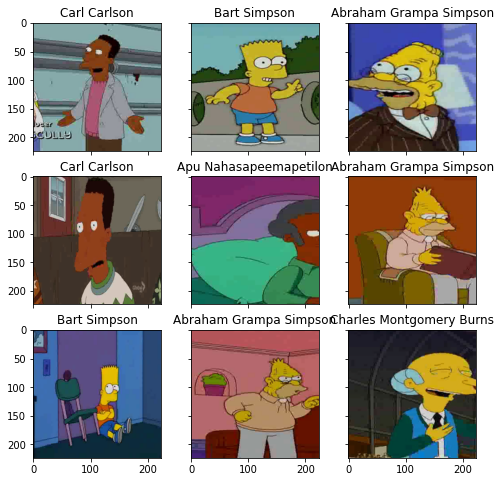

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [9]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [10]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [11]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [12]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [13]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [14]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [15]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [16]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.529018943541687


epoch:  10%|█         | 1/10 [04:41<42:15, 281.73s/it]


Epoch 001 train_loss: 2.5290     val_loss 1.8780 train_acc 0.2951 val_acc 0.4891
loss 1.5026530288375786


epoch:  20%|██        | 2/10 [07:35<29:05, 218.13s/it]


Epoch 002 train_loss: 1.5027     val_loss 1.2424 train_acc 0.5872 val_acc 0.6674
loss 0.9470152942243902


epoch:  30%|███       | 3/10 [10:27<23:00, 197.16s/it]


Epoch 003 train_loss: 0.9470     val_loss 0.9877 train_acc 0.7378 val_acc 0.7398
loss 0.6405687541276439


epoch:  40%|████      | 4/10 [13:19<18:43, 187.20s/it]


Epoch 004 train_loss: 0.6406     val_loss 0.9807 train_acc 0.8182 val_acc 0.7518
loss 0.46069742323127977


epoch:  50%|█████     | 5/10 [16:11<15:08, 181.74s/it]


Epoch 005 train_loss: 0.4607     val_loss 0.9548 train_acc 0.8667 val_acc 0.7753
loss 0.3185073606035377


epoch:  60%|██████    | 6/10 [19:03<11:54, 178.54s/it]


Epoch 006 train_loss: 0.3185     val_loss 0.9312 train_acc 0.9066 val_acc 0.7839
loss 0.22812691458669224


epoch:  70%|███████   | 7/10 [21:56<08:49, 176.45s/it]


Epoch 007 train_loss: 0.2281     val_loss 1.0935 train_acc 0.9310 val_acc 0.7895
loss 0.18668090501191875


epoch:  80%|████████  | 8/10 [24:51<05:52, 176.17s/it]


Epoch 008 train_loss: 0.1867     val_loss 1.1810 train_acc 0.9417 val_acc 0.7967
loss 0.13501306700287846


epoch:  90%|█████████ | 9/10 [27:49<02:56, 176.63s/it]


Epoch 009 train_loss: 0.1350     val_loss 1.2645 train_acc 0.9582 val_acc 0.7916
loss 0.11222071369657988


epoch: 100%|██████████| 10/10 [30:46<00:00, 184.67s/it]


Epoch 010 train_loss: 0.1122     val_loss 1.2911 train_acc 0.9661 val_acc 0.7992


Построим кривые обучения

In [17]:
loss, acc, val_loss, val_acc = zip(*history)

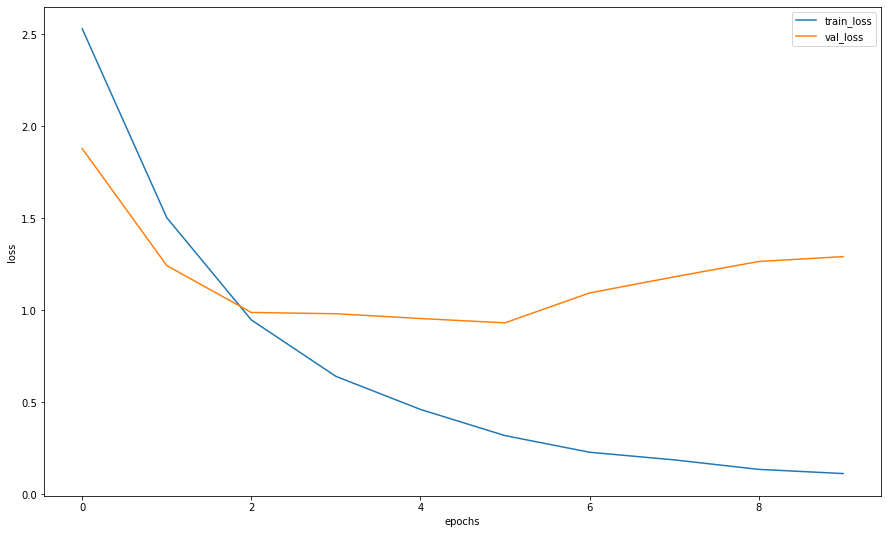

In [18]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [19]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [20]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [21]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [22]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

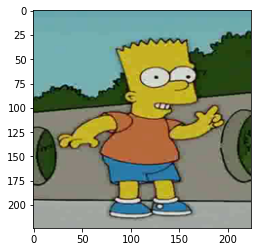

In [23]:
# """Imshow для тензоров"""
inp = imgs[0][0]
inp = inp.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
plt.imshow(inp)

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [24]:
actual_labels = []
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    logits = []

    for inputs in val_loader:
        x_val = inputs[0]
        actual_labels.append(inputs[1])
        x_val = x_val.to(DEVICE)

        simple_cnn.eval()
        outputs = simple_cnn(x_val).cpu()
        logits.append(outputs)

probs_val = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

act = [i.tolist() for i in  actual_labels]
act_flat_list = [item for sublist in act for item in sublist]

preds_val = np.argmax(probs_val, axis=1)
preds_names = label_encoder.inverse_transform(preds_val)
val_filenames = [path.parent.name for path in val_dataset.files]

f1_score(act_flat_list, preds_val, average='macro')

0.6320313783798331

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

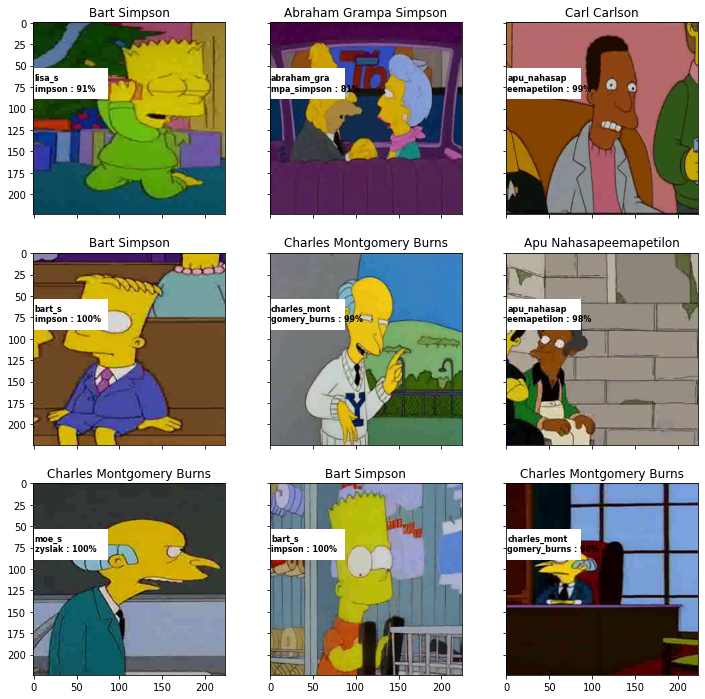

In [25]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [26]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [27]:
res = pd.DataFrame({
    'Id': test_filenames,
    'Expected':preds})
res.head(2)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson


In [28]:
res.to_csv('../working/sub.csv', index=False)

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


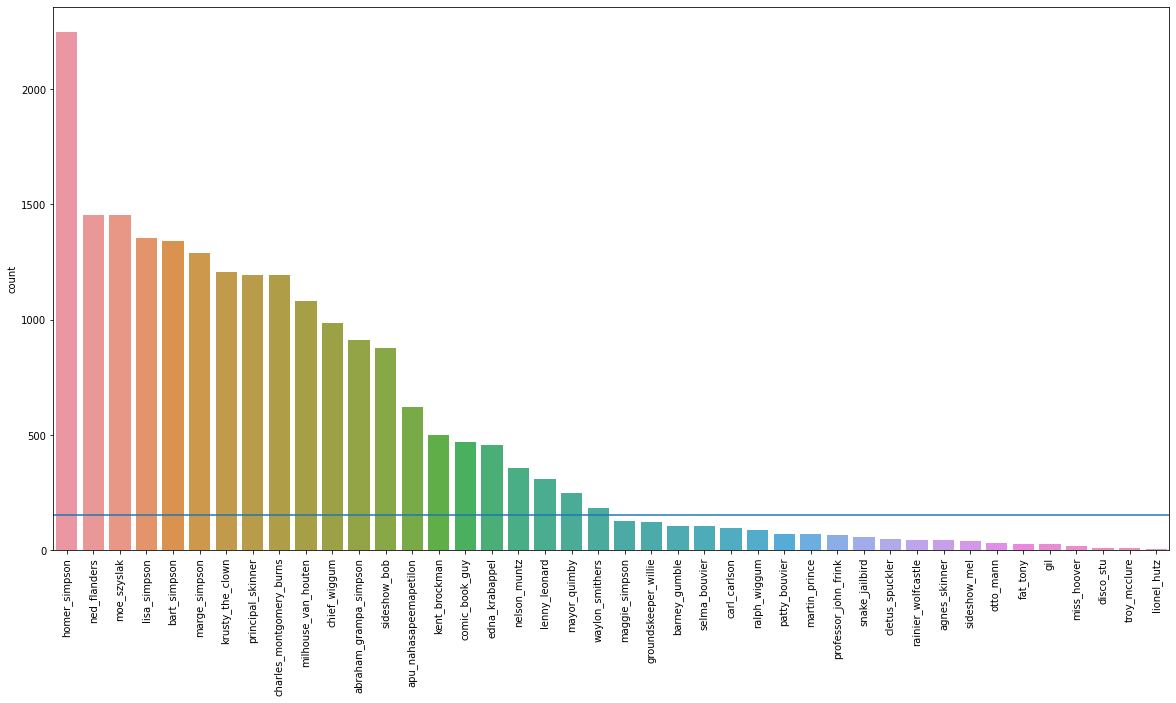

In [29]:
from collections import Counter
import seaborn as sns

data_dict = dict(Counter([x.parent.name for x in train_val_files]))
data = pd.DataFrame(data = data_dict.values(), index=data_dict.keys(), columns=['count'])
data = data.sort_values('count', ascending=False)
plt.figure(figsize=(20,10))
chart = sns.barplot(x = data.index, y = data['count'])
chart.set_xticklabels(data.index, rotation=90)
#Drawing a horizontal line 
chart.axhline(data['count'].median())
plt.show()

Большая часть классов имеет менее 1000 объектов. Если попытаться сделать "адекватный" даунсемплинг, то каждому классу будет принадлежать меньше 100 объектов, что приведёт к плохому соотношению объектов к классам и сильно усложнит задачу обучения. Поэтому, сделаем оверсемплинг с помощью аугментации


In [30]:
augmenters = {
    'center_random_crop': transforms.Compose([
        transforms.Resize(300, max_size=301),
        transforms.CenterCrop(300),
        transforms.RandomCrop(250)        
    ]),
    'perspective':        transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.3, p=1.0),    
    ]),
    'horizontal_flip':    transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
    ]),
    'rotate':             transforms.Compose([
        transforms.RandomRotation(degrees = (-25, 25))
    ]),
    'comb':               transforms.Compose([
        transforms.Resize(300, max_size=301),
        transforms.RandomRotation(degrees = (-25, 25)),
        transforms.RandomPerspective(distortion_scale=0.3, p=1.0),  
        transforms.CenterCrop(300),
        transforms.RandomCrop(250)   
        
    ]),
}

plot augmenters

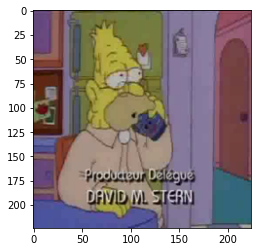

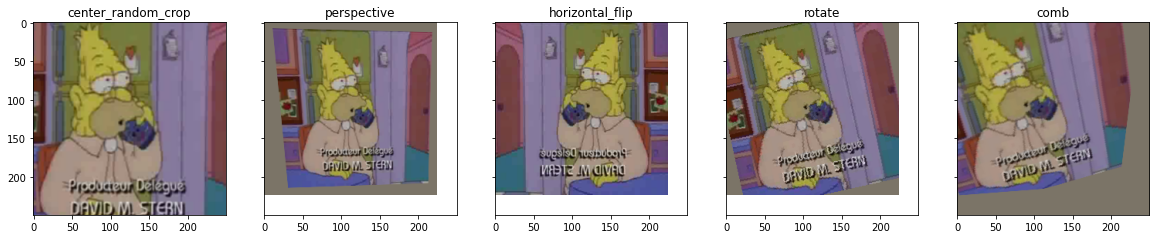

In [31]:
im_val, _ = val_dataset[0]
inp = im_val
inp = inp.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
plt.imshow(inp)


fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20, 6), \
                        sharey=True, sharex=True)
list_of_augs = list(zip( ax.flatten(), augmenters.keys()))

for fig_x, aug in list_of_augs:
    name = aug
    a = augmenters[aug]

    im_val, _ = val_dataset[0]
    inp = a(im_val)
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    fig_x.imshow(inp)
    fig_x.set_title(aug)

In [32]:
lt1500 = data['count']<700

data.loc[lt1500, 'add'] = 700-data['count']
data.loc[~lt1500, 'add'] = 0
data['from_1_image'] = (np.ceil(data['add'] / data['count'])).astype(int)

In [33]:
data

,count,add,from_1_image
homer_simpson,2246,0.0,0
ned_flanders,1454,0.0,0
moe_szyslak,1452,0.0,0
lisa_simpson,1354,0.0,0
bart_simpson,1342,0.0,0
marge_simpson,1291,0.0,0
krusty_the_clown,1206,0.0,0
principal_skinner,1194,0.0,0
charles_montgomery_burns,1193,0.0,0
milhouse_van_houten,1079,0.0,0


sampling images and saving them to training files directory

In [34]:
# for i in list(TRAIN_DIR.rglob('*augmented*.jpg')):
#     i.unlink()

# sorted(list(TRAIN_DIR.rglob('*augmented*.jpg')))

In [35]:
# import shutil
# shutil.rmtree('../working/sample')

In [36]:
import os

create_dir = Path('../working/sample')

if not os.path.isdir(create_dir):
    os.mkdir(create_dir)

In [37]:
for file_path in tqdm(sorted(train_files)):
    
    class_name  = file_path.parent.name
    folder_path = file_path.parents[0]
    
    parent_dir = Path('../working/sample')
    directory = class_name
    path = os.path.join(parent_dir, directory)

    if not os.path.isdir(path):
        os.mkdir(path)
            
    if data.loc[class_name]['add'] <= 0:
        continue
    
    sampling_size = int(data.loc[class_name]['add'])
    data.loc[class_name, 'add'] = 0
    print(f'\nclass_name, sampling_size: {class_name}, {sampling_size}')
    
    folder_files = [i for i in train_files if i.parents[0] == folder_path]
    
    for i in range(sampling_size):
        img_path = random.choice(folder_files)
        
        # load image
        image = Image.open(img_path)
        image.load()
        
        augmenter_name = random.choice(list(augmenters.keys()))
        augmenter = augmenters[augmenter_name]
        image_a = augmenter(image)
        
#         path_to_save = f'../working/sample/{class_name}/augmented_{i}.jpg'
        path_to_save = f"{path}/{file_path.name.split('.')[0]}_{i}.jpg"
        image_a.save(path_to_save)
#         print(f'saved {path_to_save}')

  4%|▍         | 637/15699 [00:00<00:02, 6368.14it/s]


class_name, sampling_size: agnes_skinner, 658

class_name, sampling_size: apu_nahasapeemapetilon, 77

class_name, sampling_size: barney_gumble, 594


 12%|█▏        | 1907/15699 [00:11<01:21, 168.33it/s]


class_name, sampling_size: carl_carlson, 602


 24%|██▍       | 3766/15699 [00:17<00:38, 308.97it/s]


class_name, sampling_size: cletus_spuckler, 653

class_name, sampling_size: comic_book_guy, 231


 27%|██▋       | 4279/15699 [00:27<01:24, 134.87it/s]


class_name, sampling_size: disco_stu, 692

class_name, sampling_size: edna_krabappel, 243


 29%|██▉       | 4619/15699 [00:35<02:02, 90.27it/s] 


class_name, sampling_size: fat_tony, 673

class_name, sampling_size: gil, 673

class_name, sampling_size: groundskeeper_willie, 579


 39%|███▊      | 6046/15699 [00:54<01:26, 111.89it/s]


class_name, sampling_size: kent_brockman, 202


 50%|████▉     | 7797/15699 [00:56<00:26, 303.81it/s]


class_name, sampling_size: lenny_leonard, 390

class_name, sampling_size: lionel_hutz, 697


 56%|█████▌    | 8736/15699 [01:06<00:40, 169.84it/s]


class_name, sampling_size: maggie_simpson, 572


 62%|██████▏   | 9745/15699 [01:12<00:31, 187.86it/s]


class_name, sampling_size: martin_prince, 629


 64%|██████▍   | 10121/15699 [01:18<00:44, 126.77it/s]


class_name, sampling_size: mayor_quimby, 454


 70%|███████   | 11023/15699 [01:23<00:28, 164.82it/s]


class_name, sampling_size: miss_hoover, 683


 84%|████████▍ | 13225/15699 [01:30<00:06, 390.47it/s]


class_name, sampling_size: nelson_muntz, 342

class_name, sampling_size: otto_mann, 668

class_name, sampling_size: patty_bouvier, 628


 91%|█████████▏| 14349/15699 [01:45<00:09, 148.37it/s]


class_name, sampling_size: professor_john_frink, 635

class_name, sampling_size: ralph_wiggum, 611


 94%|█████████▎| 14685/15699 [02:03<00:16, 60.53it/s] 


class_name, sampling_size: selma_bouvier, 597


 98%|█████████▊| 15389/15699 [02:08<00:03, 88.11it/s]


class_name, sampling_size: sideshow_mel, 660

class_name, sampling_size: snake_jailbird, 645


 99%|█████████▉| 15517/15699 [02:21<00:03, 47.44it/s]


class_name, sampling_size: troy_mcclure, 692


 99%|█████████▉| 15558/15699 [02:31<00:04, 31.97it/s]


class_name, sampling_size: waylon_smithers, 519


100%|██████████| 15699/15699 [02:36<00:00, 100.36it/s]


In [38]:
SAMPLE_DIR = Path('/kaggle/working/sample')

train_sample_files = sorted(list(SAMPLE_DIR.rglob('*.jpg')))

sample_labels = [path.parent.name for path in train_val_files]

In [39]:
train_files.extend(train_sample_files)

In [40]:
d = dict(Counter([i.parent.name for i in train_files]))
data_new = pd.DataFrame(data = d.values(), index=d.keys(), columns=['count'])
data_new = data_new.sort_values('count', ascending=False)

In [41]:
data_new

,count
homer_simpson,1684
ned_flanders,1090
moe_szyslak,1089
lisa_simpson,1015
bart_simpson,1006
marge_simpson,968
krusty_the_clown,904
charles_montgomery_burns,895
principal_skinner,895
milhouse_van_houten,809


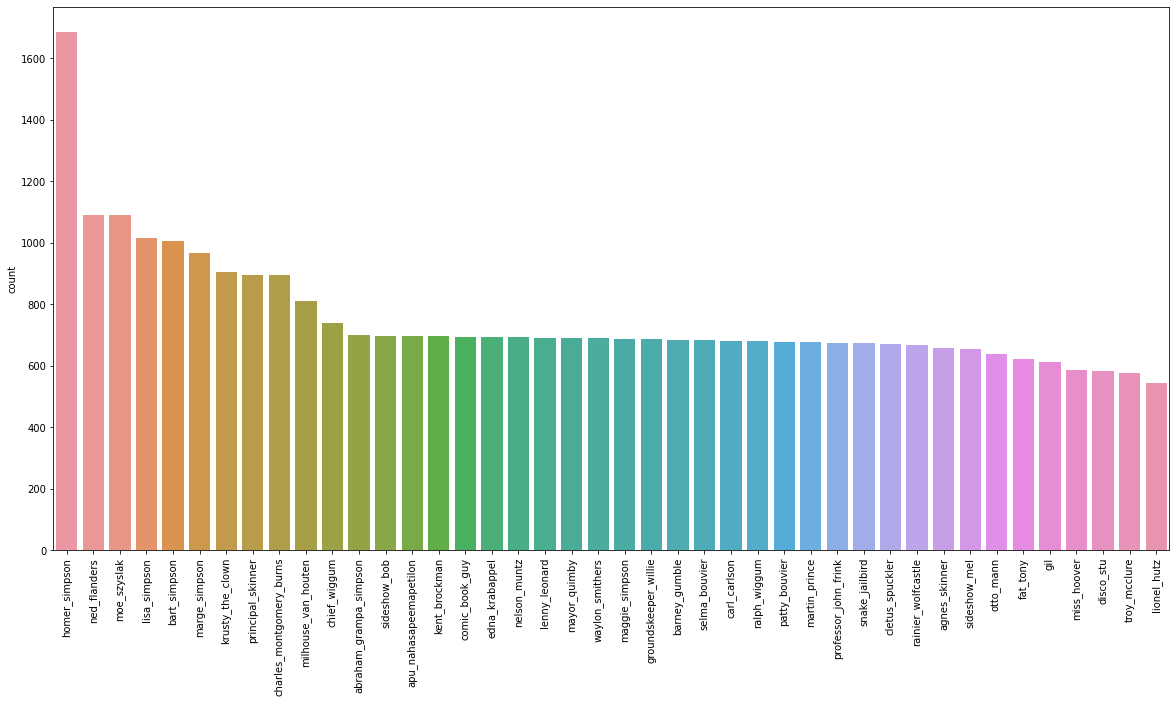

In [42]:
plt.figure(figsize=(20, 10))
g = sns.barplot(x=data_new.index, y=data_new['count'])
g.set_xticklabels(data.index, rotation=90)
plt.show()

In [43]:
train_dataset = SimpsonsDataset(train_files, mode='train')

In [46]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 0.058203667447402165


epoch:  50%|█████     | 1/2 [04:45<04:45, 285.76s/it]


Epoch 001 train_loss: 0.0582     val_loss 1.4282 train_acc 0.9828 val_acc 0.8168
loss 0.04821527411016269


epoch: 100%|██████████| 2/2 [09:31<00:00, 285.85s/it]


Epoch 002 train_loss: 0.0482     val_loss 1.7216 train_acc 0.9851 val_acc 0.8013


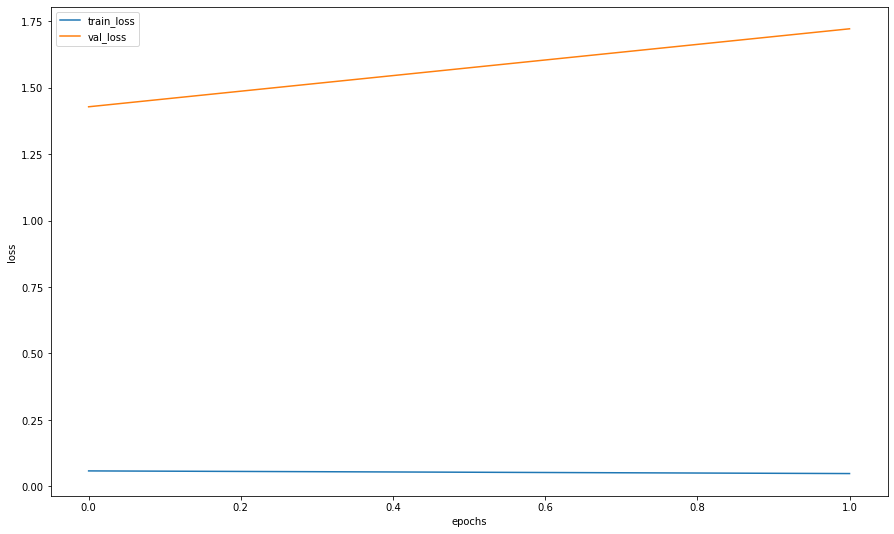

In [47]:
loss, acc, val_loss, val_acc = zip(*history)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

## calculate f1

In [48]:
actual_labels = []
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    logits = []

    for inputs in val_loader:
        x_val = inputs[0]
        actual_labels.append(inputs[1])
        x_val = x_val.to(DEVICE)

        simple_cnn.eval()
        outputs = simple_cnn(x_val).cpu()
        logits.append(outputs)

probs_val = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

act = [i.tolist() for i in  actual_labels]
act_flat_list = [item for sublist in act for item in sublist]

preds_val = np.argmax(probs_val, axis=1)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds_names = label_encoder.inverse_transform(preds_val)
val_filenames = [path.parent.name for path in val_dataset.files]

f1_score(act_flat_list, preds_val, average='macro')

0.661254764898634

## predict on test

In [49]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(simple_cnn, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

res = pd.DataFrame({
    'Id': test_filenames,
    'Expected':preds})
res.to_csv('../working/sub1.csv', index=False)

res.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


# transfer learning

In [50]:
from torchvision import models

# EfficientNet

In [53]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=bfbbea6784f9abf8f579a6e4eb3902cb9edcc626f498886732f52baf7dadc042
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
Successfully built efficientnet_pytorch


In [64]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b2')

Loaded pretrained weights for efficientnet-b2


In [56]:
model

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [59]:
for name, _ in model.named_children():
    print(name)

_conv_stem
_bn0
_blocks
_conv_head
_bn1
_avg_pooling
_dropout
_fc
_swish


In [60]:
# for param in model.parameters():
#     param.requires_grad_(False)

In [61]:
# for param in model.block1.parameters():
#     param.requires_grad_(True)
# for param in model.block2.parameters():
#     param.requires_grad_(True)

In [65]:
# Размер входных свойств у классификатора модели - 1408
num_features = 1408
# Заменяем Fully-Connected слой на наш линейный классификатор
# model.classifier = nn.Linear(num_features, amount)
model.classifier  = nn.Sequential(
    nn.Linear(in_features=1408, out_features=4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=4096, out_features=42, bias=True)
)

# Использовать ли GPU
model = model.cuda()

In [67]:
history = train(train_dataset, val_dataset, model=model, epochs=2, batch_size=100)

epoch:   0%|          | 0/2 [00:00<?, ?it/s]

loss 0.13347758905812582


epoch:  50%|█████     | 1/2 [09:51<09:51, 591.34s/it]


Epoch 001 train_loss: 0.1335     val_loss 0.1764 train_acc 0.9647 val_acc 0.9585
loss 0.07368743897112966


epoch: 100%|██████████| 2/2 [19:45<00:00, 592.77s/it]


Epoch 002 train_loss: 0.0737     val_loss 0.1967 train_acc 0.9798 val_acc 0.9538


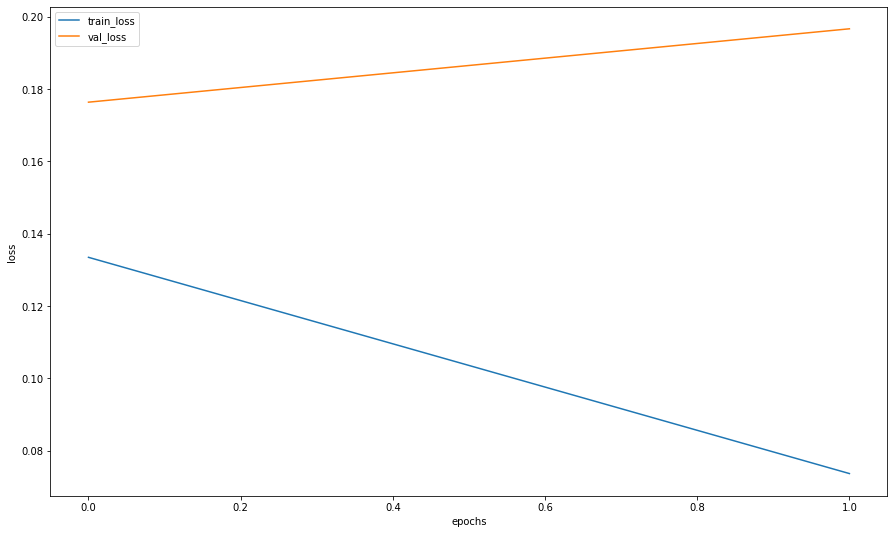

In [69]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [70]:
actual_labels = []
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

with torch.no_grad():
    logits = []

    for inputs in val_loader:
        x_val = inputs[0]
        actual_labels.append(inputs[1])
        x_val = x_val.to(DEVICE)

        simple_cnn.eval()
        outputs = model(x_val).cpu()
        logits.append(outputs)

probs_val = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

act = [i.tolist() for i in  actual_labels]
act_flat_list = [item for sublist in act for item in sublist]

preds_val = np.argmax(probs_val, axis=1)
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds_names = label_encoder.inverse_transform(preds_val)
val_filenames = [path.parent.name for path in val_dataset.files]

f1_score(act_flat_list, preds_val, average='macro')

0.8854266711831128

In [71]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

res = pd.DataFrame({
    'Id': test_filenames,
    'Expected':preds})
res.to_csv('sub3.csv', index=False)

res.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
